In [11]:
%matplotlib widget
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import string
from scipy import stats
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import GammaRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.linear_model import Lasso

from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from wordcloud import WordCloud, STOPWORDS
from dataprep.clean import clean_df


0       4.66
1       4.64
2       4.63
3       4.77
4       4.34
        ... 
7561    4.82
7562    4.82
7563    4.82
7564    4.82
7565    4.82
Name: review_scores_location, Length: 7566, dtype: float64


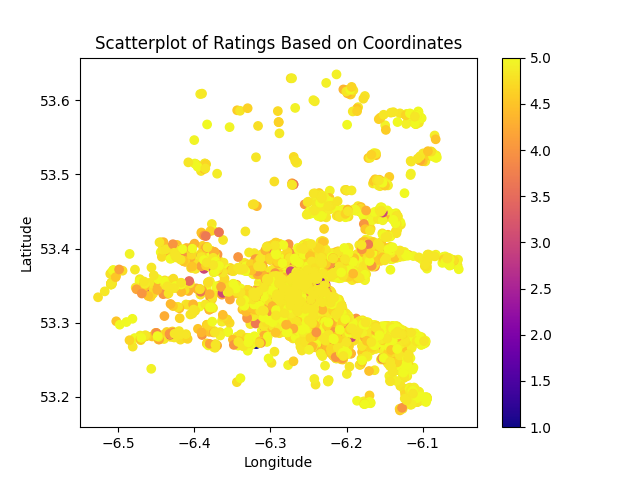

In [58]:
listingsDir = os.path.abspath('../Data/listings.csv')
reviewsDir = os.path.abspath('../Data/reviews.csv')
listings = pd.read_csv(listingsDir)
reviews = pd.read_csv(reviewsDir)
listings = pd.DataFrame(listings)
df = pd.DataFrame()
locations = listings.neighbourhood
locationsCL = listings.neighbourhood_cleansed
lat = listings.latitude
long = listings.longitude
df_y = listings.review_scores_location
df_y.fillna(df_y.median(), inplace=True)
df = pd.DataFrame(locations, locationsCL,lat,long,df_y)
x1=df.iloc[:,2]
#x1.fillna(x1.mean(), inplace=True)
x2=df.iloc[:,3]

x2.fillna(x2.mean(), inplace=True)
df_x=np.column_stack((long,lat))
print(df_y)
#y=df.iloc[:,4]
#print(listings['review_scores_rating'].describe())
#listings['review_scores_rating'].hist(bins=30)
            
df = shuffle(df)

fig = plt.figure()
#ax = fig.add_subplot()
norm_lat=(lat-lat.min())/(lat.max()-lat.min())
norm_long=(long-long.min())/(long.max()-long.min())
norm_y=(df_y-df_y.min())/(df_y.max()-df_y.min())
cm = plt.cm.get_cmap('plasma')
plt.scatter(long,lat,c=df_y,cmap=cm)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
cbar = plt.colorbar()
plt.title('Scatterplot of Ratings Based on Coordinates')
plt.show()

In [280]:
cv = CountVectorizer(min_df=2, max_df=90, lowercase='True', encoding="ascii",ngram_range=(1, 2), stop_words = 'english')
tfidV = TfidfVectorizer(min_df=2, max_df=90, lowercase='True', encoding="ascii",ngram_range=(1, 2), stop_words = 'english')

In [43]:
model = LinearRegression()
#model = PoissonRegressor()
#model = TweedieRegressor()
#model = GammaRegressor() # struggles with 0 values
#model = DummyRegressor(strategy="median")
#model = Ridge(alpha=5)
#model = RandomForestRegressor(n_estimators = 10, max_depth=8, random_state = 0)

In [ ]:
def best_poly_and_c(X, y, title):
    fig = plt.figure()
    poly_test = [0,1,2,3,4,5,6,7,8,9,10]
    Cs = [0.001,0.01,0.05,0.1,0.25,0.5,1,1.5]

    for p in poly_test:
        avg_accuracy=[]
        std_err=[]
        poly_x = PolynomialFeatures(p).fit_transform(X)

        for c in Cs:
            model = Lasso(alpha=1/(2*c))
            scores = cross_val_score(model, poly_x, y,cv=5, scoring="accuracy")
            avg_accuracy.append(scores.mean())
            std_err.append(scores.std())

        plt.errorbar(Cs, avg_accuracy,  label="Degree = {0}".format(p), yerr=std_err,)
        plt.xlabel('C')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.title(title)
    plt.legend(loc = 1)
    plt.show()
    return

best_poly_and_c(df_x,df_y, "Dataset 1")

In [65]:
C = [1,10,100,1000,10000]
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y)

for Ci in C:
    model = Lasso(alpha=1/(2*Ci)).fit(x_train,y_train)
    print("\nC value: "+str(Ci))
    print("Lasso coef: "+str(model.coef_))
    print("Lasso intercept: "+str(model.intercept_))
    print("J(θ) = %f\n"%mean_squared_error(y_test, model.predict(x_test)))

#scores = cross_val_score(model, df_x, df_y,cv=5, scoring="accuracy")
avg_accuracy = []
std_err = []
#avg_accuracy.append(scores.mean())
#std_err.append(scores.std())


C value: 1
Lasso coef: [ 0. -0.]
Lasso intercept: 4.749511808248149
J(θ) = 0.110446


C value: 10
Lasso coef: [ 0. -0.]
Lasso intercept: 4.749511808248149
J(θ) = 0.110446


C value: 100
Lasso coef: [ 0. -0.]
Lasso intercept: 4.749511808248149
J(θ) = 0.110446


C value: 1000
Lasso coef: [ 0.47144882 -0.        ]
Lasso intercept: 7.698451447653445
J(θ) = 0.108876


C value: 10000
Lasso coef: [ 0.58578173 -0.04733392]
Lasso intercept: 10.938677814636351
J(θ) = 0.108775



In [283]:
#y_train = y_train.values.astype("float32")
#model.fit(x_train_fit,y_train+0.001)
model.fit(x_train_fit,y_train)

RandomForestRegressor(max_depth=8, n_estimators=10, random_state=0)

In [284]:
#test sentences
test=tfidV.transform(["The apartment was really bad"])
output = model.predict(test)
print(output)
#Predict unseen data
y_pred =model.predict(x_test_fit)
scores = model.score(x_test_fit, y_test+0.01)

# RMSE (Root Mean Square Error)
rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)),'.3f'))
print("\nRMSE:\n",rmse)

[4.74497727]

RMSE:
 0.246


In [285]:
x = df_x.drop(df_x.index[0:int(len(df_x)/2)]).values
y = df_y.drop(df_y.index[0:int(len(df_y)/2)]).values

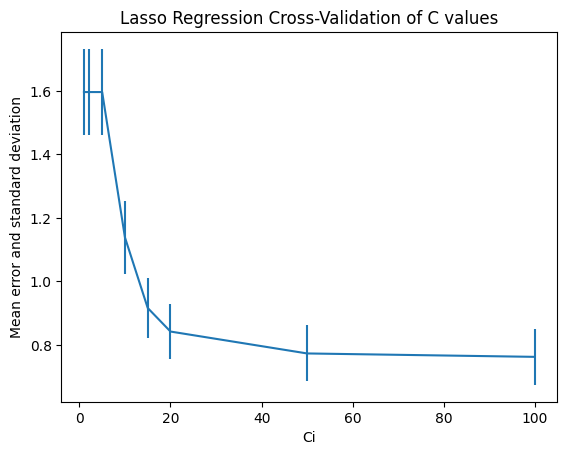

In [286]:
kf = KFold(n_splits=5)
mean_error=[]
std_error=[]
Cs2 = [1,2,5,10,15,20,50,100]
for Ci in Cs2:
    model = Lasso(alpha=1/(2*Ci))
    #print("\nC: "+str(Ci))
    kf = KFold(n_splits=6)
    temp = []
    for train, test in kf.split(x):
        x_train_fit=tfidV.fit_transform(x[train])
        x_test_fit=tfidV.transform(x[test])
        model.fit(x_train_fit,y[train])
        ypred = model.predict(x_test_fit)
        #print("Lasso coeff: "+str(model.coef_))
        temp.append(mean_squared_error(y[test],ypred))
    mean_error.append(np.array(temp).mean())
    std_error.append(np.array(temp).std())

plt.figure(dpi=100)
plt.errorbar(Cs2,mean_error,yerr=std_error)
plt.xlabel('Ci'); plt.ylabel('Mean error and standard deviation')
plt.title('Lasso Regression Cross-Validation of C values')
plt.show()

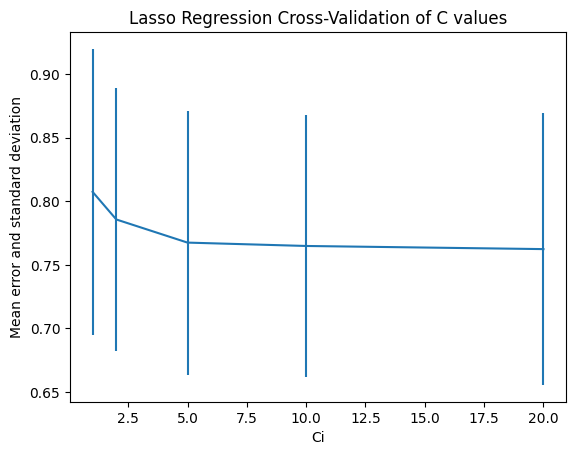

In [296]:
kf = KFold(n_splits=5)
mean_error=[]
std_error=[]
max_depths = [1,2,5,10,20]
for depth in max_depths:
    model = RandomForestRegressor(n_estimators = depth, max_depth=1, random_state = 0)
    #print("\nC: "+str(Ci))
    kf = KFold(n_splits=6)
    temp = []
    for train, test in kf.split(x):
        x_train_fit=tfidV.fit_transform(x[train])
        x_test_fit=tfidV.transform(x[test])
        model.fit(x_train_fit,y[train])
        ypred = model.predict(x_test_fit)
        #print("Lasso coeff: "+str(model.coef_))
        temp.append(mean_squared_error(y[test],ypred))
    mean_error.append(np.array(temp).mean())
    std_error.append(np.array(temp).std())

plt.figure(dpi=100)
plt.errorbar(max_depths,mean_error,yerr=std_error)
plt.xlabel('Ci'); plt.ylabel('Mean error and standard deviation')
plt.title('Lasso Regression Cross-Validation of C values')
plt.show()

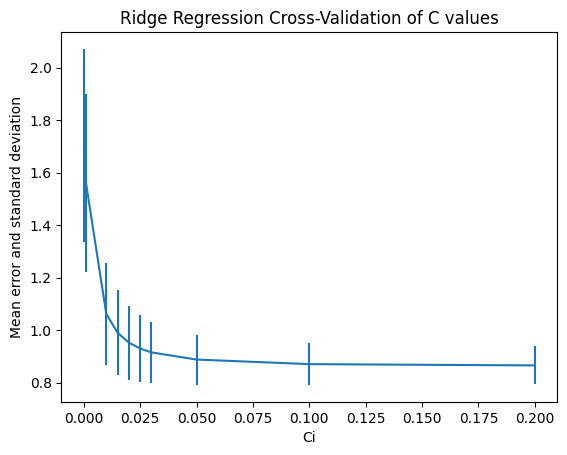

In [254]:
mean_error=[]
std_error=[]
C_ridge2 = [0.0001,0.001,0.01,0.015,0.02,0.025,0.03,0.05,0.1,0.2]
for Ci in C_ridge2:
    model = Ridge(alpha=1/(2*Ci))
    kf = KFold(n_splits=5)
    temp = []
    for train, test in kf.split(x):
        x_train_fit=tfidV.fit_transform(x[train])
        x_test_fit=tfidV.transform(x[test])
        model.fit(x_train_fit,y[train])
        ypred = model.predict(x_test_fit)
        #print("Lasso coeff: "+str(model.coef_))
        temp.append(mean_squared_error(y[test],ypred))
    #print("\nC: "+str(Ci))
    mean_error.append(np.array(temp).mean())
    std_error.append(np.array(temp).std())

plt.figure(dpi=100)
plt.errorbar(C_ridge2,mean_error,yerr=std_error)
plt.xlabel('Ci'); plt.ylabel('Mean error and standard deviation')
plt.title('Ridge Regression Cross-Validation of C values')
plt.show()

In [276]:
#x_train_fit=tfidV.fit_transform(x[train])
#x_test_fit=tfidV.transform(x[test])
model.fit(x_train_fit, y[train])
print(model)
kf = KFold(n_splits=5)
temp = []
for train, test in kf.split(x):
    x_train_fit=tfidV.fit_transform(x[train])
    x_test_fit=tfidV.transform(x[test])
    model.fit(x_train_fit,y[train])
    ypred = model.predict(x_test_fit)
    #print("Lasso coeff: "+str(model.coef_))
    temp.append(mean_squared_error(y[test],ypred))
print("mean square error = %f\n"%np.array(temp).mean())
print("standard deviatioin = %f\n"%np.array(temp).std())

RandomForestRegressor(max_depth=8, n_estimators=10, random_state=0)
mean square error = 0.985403

standard deviatioin = 0.199000



In [172]:
def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='black',
                          min_font_size = 10
                         ).generate(" ".join(data.values))                      
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=30)
    plt.show()

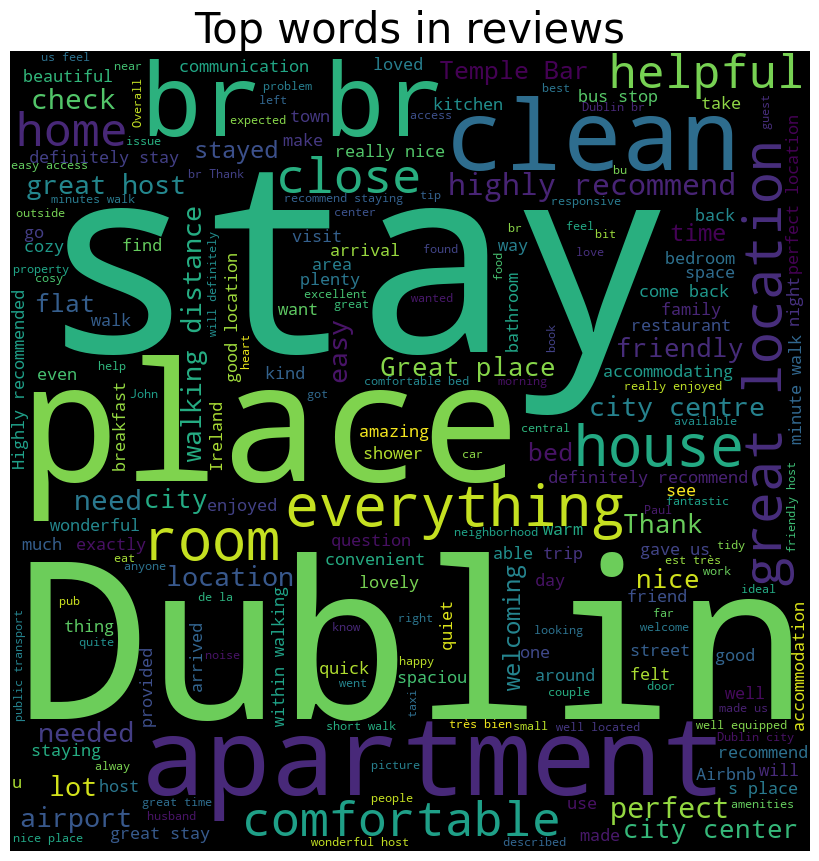

In [174]:
wordCloud_generator(df_x, title="Top words in reviews")